*****************************************
# Artificial Event Simulation
*****************************************

In this tutorial, we present the simulation of artificial events. By this we mean a very different thing, than the mock data we generated in the first tutorial notebook. The mock data was supposed to consistent with the data formats from real measurements. The artificial event generation presented here has in contrary its focus on an as realistic as possible event shape and noise properties. Such artificial events we need for several methods of our analysis, that we will explain in the following.

In [1]:
import cait as ai
import matplotlib.pyplot as plt
import numpy as np
%config InlineBackend.figure_formats = ['svg']  # we need this for a suitable resolution of the plots

In [2]:
path_data = 'test_data/'
fname = 'test_001'
channels_rdt = [0,1]
channels_h5 = [0,1]

In [3]:
dh = ai.DataHandler(channels=channels_rdt)
dh.set_filepath(path_h5=path_data,
                fname=fname,
                appendix=False)  # this specifies, that the file does not have a "-P_Ch0..." appendix

DataHandler Instance created.


## Resolution

One of the typical applications of event simulation is the determination of the baseline resolution. For this we superpose the standard event with slight time shifts to the noise baselines. We then measure the pulse height with our usual methods of pulse height estimation. This is an precise estimator of the standard deviation of our noise, not biased by drifts and relatively robust to accidentally recorded sub-threshold events on our empty baselines, as they would only interfere in the narrow region of the standard event peak with our pulse height estimation.

We have a limited number of baselines available, there we can do a trick: We increase the used time shift, as our methods are mostly agnostic to onset positions, or implemented such that they can handle them. By this effectively pick a different region of the baseline to measure its standard deviation every time and can so re-use the same baseline multiple times. It is still important to clean the baseline before we use them, therefore we take the fit errors of the polynomial baseline fit from the previous notebook and impose an upper threshold of the usage, depending on this fit error. As our mock baselines are all clean, this would not be necessary, for dealing with actual measured baselines, it is however essential.

In [4]:
dh.simulate_pulses(path_sim='test_data/resolution_001.h5',
                   size_events=500,  # should be below Nmbr of clean baselines, otherwise activate reuse_bl
                   reuse_bl=True,
                   ev_discrete_phs=[[1], [1]],
                   t0_interval=[-20, 20],  # in ms
                   rms_thresholds=[1, 1],
                   fake_noise=False)

Simulating Events.
Get Baselines.
Nmbr resets to start of Baseline dataset: 0
Nmbr resets to start of Baseline dataset: 1
Nmbr resets to start of Baseline dataset: 2
Get Pulse Heights.
Add Pulses to Baselines.
Fitting baselines.



Fitting baselines.



Store OF.
Simulation done.


To determine the baseline resolution, we build our pulse height estimators for the simulated baselines.

In [5]:
dh_res = ai.DataHandler(channels=[0,1])
dh_res.set_filepath(path_h5='test_data/', fname='resolution_001', appendix=False)

dh_res.apply_of()
dh_res.calc_mp(type='events')
dh_res.apply_sev_fit(type='events', down=1, verb=True)

DataHandler Instance created.
Calculating OF Heights.
CALCULATE MAIN PARAMETERS.
Calculating SEV Fit.
Fitting channel 0.



Fitting channel 1.



Done.


In the pulse height spectrum of the methods we can see that the estimated pulse height is roughly Gaussian distributed around the true pulse height, as we expected. There are however differences in the quality of the resolution, i.e. the width of the Gauss peak. 

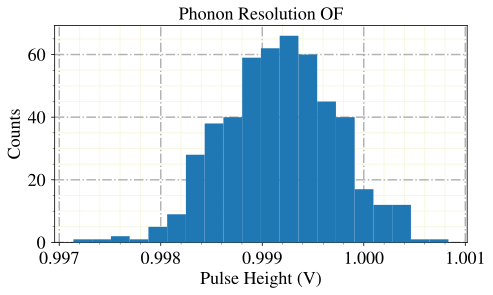

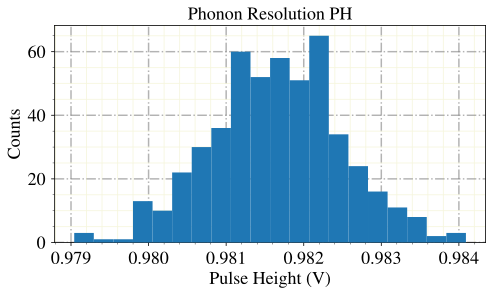

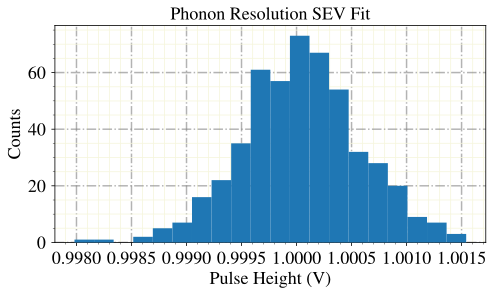

In [6]:
dh_res.show_values(group='events', key='of_ph', bins=20, idx0=0, 
               xlabel='Pulse Height (V)', ylabel='Counts', title='Phonon Resolution OF')
dh_res.show_values(group='events', key='mainpar', bins=20, idx0=0, idx2=0,
               xlabel='Pulse Height (V)', ylabel='Counts', title='Phonon Resolution PH')
dh_res.show_values(group='events', key='sev_fit_par', bins=20, idx0=0, idx2=0,
               xlabel='Pulse Height (V)', ylabel='Counts', title='Phonon Resolution SEV Fit')

For the calculation of the resolution, we have multiple options. The most common approach is to fit a Gauss to the peak in the spectrum and determine so a standard deviation. As a quicker and still unbiased estimator, we can use the sample standard deviation. Also, if we have for whatever reason not the option to simulate events, we can take instead  one of the lower energetic test pulses.

In [7]:
resolutions_ph, mus_ph = dh_res.calc_resolution(pec_factors=None, ph_intervals=[(0,2), (0,2)], 
                                      use_tp=False, of_filter=False, sev_fit=False, fit_gauss=True)
resolutions_of, mus_of = dh_res.calc_resolution(pec_factors=None, ph_intervals=[(0,2), (0,2)], 
                                      use_tp=False, of_filter=True, sev_fit=False, fit_gauss=True)
resolutions_fit, mus_fit = dh_res.calc_resolution(pec_factors=None, ph_intervals=[(0,2), (0,2)], 
                                      use_tp=False, of_filter=False, sev_fit=True, fit_gauss=True)

Calculating resolution.
Resolution channel 0: 0.825 mV (mean 0.982 V, calculated with Pulse Heights)
Resolution channel 1: 1.23 mV (mean 0.999 V, calculated with Pulse Heights)
Calculating resolution.
Resolution channel 0: 0.559 mV (mean 0.999 V, calculated with Optimum Filter)
Resolution channel 1: 0.551 mV (mean 1.01 V, calculated with Optimum Filter)
Calculating resolution.
Resolution channel 0: 0.537 mV (mean 1.0 V, calculated with Standard Event Fit)
Resolution channel 1: 0.429 mV (mean 1.0 V, calculated with Standard Event Fit)


We observe the lowest resolution with the optimum filter, and an almost as low one with the standard event fit. The resolution with the raw pulse height is less precise. Here it is probabliy a good point to mention a detail about the calculation of main parameters: Before the calculation of pulse height, position, etc the event is smoothed with a 50 sample average kernel to reduce the amount of noise. This has as effect, that the estimation of the pulse height is negatively biased from the raw pulse height/main parameters, probably contrary to our intuition about our additive noise.

## Cut Efficiency

Another application for simulated events is the determination of a cut efficiency. For this we simulate a large number of pulses with uniformly distributed pulse heights over the whole linear detector region. Then we apply all cuts that we do to the events in our analysis and measure how many recoil events survive the cuts, depending on their true pulse height, i.e. their true energy. We again reuse baselines and avoid systematic errors in our statistics by a time shift and the fact, that very unlikely two pulses with the same height end up at the same reused baseline.

Here, we do no cleaning of the baselines, ergo we set the rms_thresholds to very high values! We want all possible artifacts and pile up considered for the efficiency simulation.

In [8]:
dh.simulate_pulses(path_sim='test_data/efficiency_001.h5',
                   size_events=500,  # should be below Nmbr of baselines, otherwise activate reuse_bl
                   reuse_bl=True,
                   ev_ph_intervals=[[0, 1], [0, 1]],
                   t0_interval=[-20, 20],
                   rms_thresholds=[1, 1],
                   fake_noise=False)

Simulating Events.
Get Baselines.
Nmbr resets to start of Baseline dataset: 0
Nmbr resets to start of Baseline dataset: 1
Nmbr resets to start of Baseline dataset: 2
Get Pulse Heights.
Add Pulses to Baselines.
Fitting baselines.



Fitting baselines.



Store OF.
Simulation done.


For the sake of the argument, we use the raw pulse height as estimator for the true pulse height.

In [9]:
dh_eff = ai.DataHandler(channels=[0,1])
dh_eff.set_filepath(path_h5='test_data/', fname='efficiency_001', appendix=False)
dh_eff.calc_mp()

DataHandler Instance created.
CALCULATE MAIN PARAMETERS.


We now apply the simplest posible cut to our artificial recoil events, a cut on the estimated pulse height, i.e. a lower threshold. Just for demonstration, we also apply a second random cut, that does not make any sense.

In [10]:
ph = dh_eff.get('events', 'mainpar')[0,:,0]
survivors = ai.cuts.LogicalCut(ph > 0.2)  # threshold cut
survivors.add_condition(ph > np.random.uniform(low=0, high=0.5, size=len(ph)))  # random cut

We then typically plot a binned spectrum of the true energy/pulse height of the surviving events, normalized to the event count in the bin.

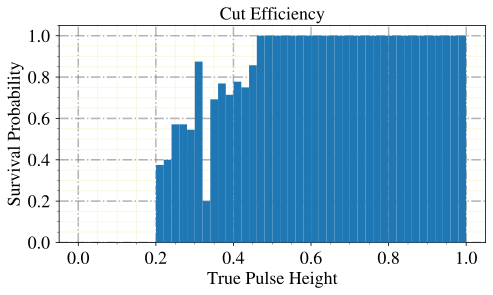

In [11]:
efficiency, counts, bins = dh_eff.show_efficiency(channel=0, 
                                                cut_flag=survivors.get_flag(), 
                                                which_quantity='true_ph', 
                                                bins=50,
                                                title='Cut Efficiency',
                                                xlabel=None,
                                                ylabel=None,
                                                show=True,
                                                dpi=150,
                                                range=None,)

In [14]:
print('Event Counts in the Bins: ', counts)
print('Bin Edges: ', bins)
print('Efficiency Values per bin: ', efficiency)

Event Counts in the Bins:  [10 14  9  5  8 17 10  9  8 17 16  5 14  7 11  8  5 13 13  7  9 12  7  8
  8 11 12 15  9 11  8  4 10 16  7  9 10  5 18  6  9  9 13  7 10  7  9 11
  9 15]
Bin Edges:  [6.29268000e-04 2.06139626e-02 4.05986572e-02 6.05833518e-02
 8.05680464e-02 1.00552741e-01 1.20537436e-01 1.40522130e-01
 1.60506825e-01 1.80491519e-01 2.00476214e-01 2.20460909e-01
 2.40445603e-01 2.60430298e-01 2.80414992e-01 3.00399687e-01
 3.20384382e-01 3.40369076e-01 3.60353771e-01 3.80338466e-01
 4.00323160e-01 4.20307855e-01 4.40292549e-01 4.60277244e-01
 4.80261939e-01 5.00246633e-01 5.20231328e-01 5.40216022e-01
 5.60200717e-01 5.80185412e-01 6.00170106e-01 6.20154801e-01
 6.40139495e-01 6.60124190e-01 6.80108885e-01 7.00093579e-01
 7.20078274e-01 7.40062968e-01 7.60047663e-01 7.80032358e-01
 8.00017052e-01 8.20001747e-01 8.39986441e-01 8.59971136e-01
 8.79955831e-01 8.99940525e-01 9.19925220e-01 9.39909914e-01
 9.59894609e-01 9.79879304e-01 9.99863998e-01]
Efficiency Values per bin:  

If we want this plot depend on true energy, rather than on the true pulse height, we have to determine the Pulse-Volt-Conversion factor, which is the energy of a known calibration peak in the spectrum, divided by its position in Volt. We can scale this linearly to the true pulse heights (i.e. just multiply it), without the need for a non-linear calibration, as we are comparing true pulse heights with true energies, without any detector effects.

## Supervised Machine Learning

The third application where we need artificial events is the training of supervised machine learning methods. For this we always need labeled data. We can follow two different approaches: First, we can label data per hand. This is adressed in another notebook. Here we create artificial data, from that we know right away way event class it belongs to. For this we take a simulation of the noise baselines, that is consistent in its noise power spectrum and drift structure. In experiments, models that were trained on simulated baselines performed roughly as good on measured baselines as one that was trained on measured ones. By using the simulated noise, we increase our statistics and prevent overfitting to some reused baseline. We allow for time shifts and sample uniformly in the linear region of the detector, to achieve good generalization.

The simulation works in two steps, first we simulate absorber events.

In [4]:
dh.simulate_pulses(path_sim='test_data/absorbers_001.h5',
                   size_events=3000,
                   size_noise=3000,
                   ev_ph_intervals=[[0, 0.15], [0, 0.15]],
                   t0_interval=[-150, 450],
                   rms_thresholds=[1, 1],
                   assign_labels=[1],
                   fake_noise=True,  # we simulate new baselines so we are not limited from the nmbr of baselines
                  )

Simulating Events.
Get Baselines.
Simulating Polynomials.
Calculating Polynomial NPS.
Simulating Noise with difference NPS.



Baseline Simulation done.
Get Pulse Heights.
Add Pulses to Baselines.
Fitting baselines.



Fitting baselines.



Simulating Noise.
Get Baselines.
Simulating Polynomials.
Calculating Polynomial NPS.
Simulating Noise with difference NPS.



Baseline Simulation done.
Get Pulse Heights.
Add Pulses to Baselines.
Store OF.
Simulation done.


Second, we simulate carrier events.

In [5]:
dh.simulate_pulses(path_sim='test_data/carriers_001.h5',
                   size_events=3000,  
                   exceptional_sev_naming='stdevent_carrier',
                   channels_exceptional_sev=[0],
                   ev_ph_intervals=[[0, 0.15], [0, 0.15]],
                   t0_interval=[-150, 450],
                   rms_thresholds=[1, 1],
                   assign_labels=[8],
                   fake_noise=True,
                  )

Simulating Events.
Get Baselines.
Simulating Polynomials.


/Users/felix/PycharmProjects/cait/cait/mixins/_data_handler_simulate.py:123: UserWarning: The exceptional standard events are with version 1.0 depricated. Please use the name_appendix argument instead!
  warnings.warn('The exceptional standard events are with version 1.0 depricated. '


Calculating Polynomial NPS.
Simulating Noise with difference NPS.



Baseline Simulation done.
Get Pulse Heights.
Add Pulses to Baselines.
Fitting baselines.



Fitting baselines.



Store OF.
Simulation done.


Now we merge these two datasets and by this construct a labeled set of artificial events. We define to additionally copy the standardevent and the optimumfilter from the set of absorber pulses, to calcualte standard event fits and optimum filter pulse height estimators at a later point. 

In [6]:
ai.data.merge_h5_sets(path_h5_a='test_data/absorbers_001.h5', 
                      path_h5_b='test_data/carriers_001.h5', 
                      path_h5_merged='test_data/low_detection_001.h5', 
                      groups_from_a=['stdevent', 'optimumfilter'],
                      continue_hours=False,
                      keep_original_files=True)

Merge done.


Okay, we now want to see what we can do with this data set. So first we calculate some features, to try some event distrimination.

In [3]:
dh_lab = ai.DataHandler(nmbr_channels=2)
dh_lab.set_filepath(path_h5='test_data/',
                fname='low_detection_001',
                appendix=False)  # this specifies, that the file does not have a "-P_Ch0..." appendix

dh_lab.calc_mp()

dh_lab.apply_sev_fit(down=8, t0_bounds=(-150, 450), first_channel_dominant=True)

dh_lab.calc_additional_mp()

dh_lab.apply_pca(nmbr_components=16)

DataHandler Instance created.
CALCULATE MAIN PARAMETERS.
Calculating SEV Fit.



Done.
CALCULATE ADDITIONAL MAIN PARAMETERS.
Channel  0
Fitting ...
Explained Variance:  [0.07904974 0.01882696 0.01453974 0.01216425 0.01111868 0.01035676
 0.0096497  0.00951837 0.0094399  0.00899501 0.00881804 0.00863134
 0.00854212 0.0083291  0.00825939 0.00731923]
Singular Values:  [25.72191788 12.55287455 11.03142283 10.09010754  9.64672374  9.31033057
  8.98690207  8.92553909  8.88866993  8.6766859   8.5909101   8.49947924
  8.45543711  8.34934044  8.31432885  7.82682732]
Saving predictions ...



Channel  1
Fitting ...
Explained Variance:  [0.22587664 0.07024093 0.06612208 0.05591535 0.04810989 0.04072245
 0.03447621 0.0296035  0.0253358  0.02161722 0.0183987  0.01612125
 0.01409104 0.01229026 0.01069356 0.00950562]
Singular Values:  [94.31378949 52.59381399 51.02849665 46.9250851  43.52679824 40.04575472
 36.84675757 34.14374002 31.58688866 29.1769207  26.91739855 25.1964222
 23.55651748 21.99986931 20.52110475 19.34771874]
Saving predictions ...


To try some cuts, we take the needed quantities from the data set.

In [4]:
ph = dh_lab.get('events', 'mainpar')[0,:,0]
ph_light = dh_lab.get('events', 'mainpar')[1,:,0]
decay_time = (dh_lab.get('events','mainpar')[0,:,6] - dh_lab.get('events','mainpar')[0,:,4])/dh_lab.sample_frequency
pca_proj = dh_lab.get('events', 'pca_projection')[0,:,:]

We repeat the cut on the decay time, which worked very well in a previous notebook.

In [5]:
absorbers = ai.cuts.LogicalCut(initial_condition=decay_time > 0.004)
carriers = ai.cuts.LogicalCut(absorbers.get_antiflag())

By plotting the decay time with respect to the pulse height, we see again that this quantitiy has good discriminative properties. However, for the low energetic region we see already that there might occur some mixing between these event classes. 

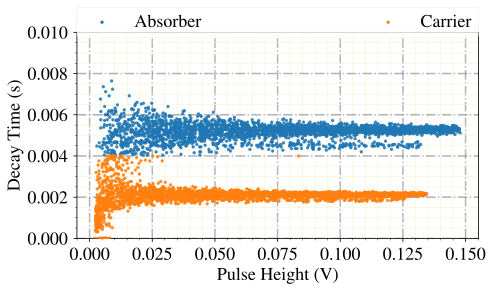

In [7]:
plt.close()
ai.styles.use_cait_style(dpi=150)
plt.scatter(ph[absorbers.get_flag()], decay_time[absorbers.get_flag()], marker='.', alpha=0.9, zorder=10, label='Absorber')
plt.scatter(ph[carriers.get_flag()], decay_time[carriers.get_flag()], marker='.', alpha=0.9, zorder=10, label='Carrier')
ai.styles.make_grid()
plt.xlabel('Pulse Height (V)')
plt.ylabel('Decay Time (s)')
#plt.xlim([0,5])
plt.ylim([0,0.01])
legend = plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), mode="expand", borderaxespad=0., ncol=3)
for lh in legend.legendHandles:
    lh.set_alpha(1.0)
plt.show()

Lets see if the principal component analysis also has such good discrimination power.

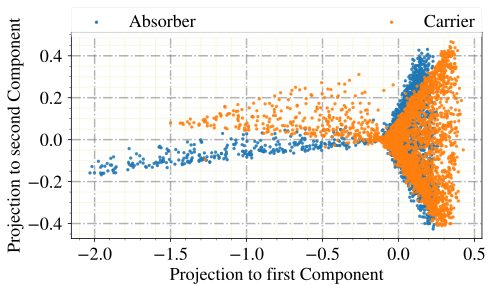

In [8]:
plt.close()
ai.styles.use_cait_style(dpi=150)
plt.scatter(pca_proj[absorbers.get_flag(),0], pca_proj[absorbers.get_flag(),1], marker='.', alpha=0.9, zorder=10, label='Absorber')
plt.scatter(pca_proj[carriers.get_flag(),0], pca_proj[carriers.get_flag(),1], marker='.', alpha=0.9, zorder=10, label='Carrier')
ai.styles.make_grid()
plt.xlabel('Projection to first Component')
plt.ylabel('Projection to second Component')
legend = plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), mode="expand", borderaxespad=0., ncol=3)
for lh in legend.legendHandles:
    lh.set_alpha(1.0)
plt.show()

Well, this did not work out as expected. What we observe here is the effect of the time shift. The PCA, as a linear method, calculates projections to the two templates that reproduce best the variations in the data. It is not capable of rolling the templates along the time axis though. So the time shift increases the range of the events in the high dimensional space of sample values significantly, and therefore increases the information loss that comes with the projection to the low dimensional space of principal components.

### View Artificial Events

Finally we want to see the simulated events. This we can do in the EventInterface, which was initially only supposed to be an easy interface to label events. However, it is also very useful to just view the events, which we will do here. In a later notebook, we will use it for actually labeling the events.

In [15]:
ei = ai.EventInterface(nmbr_channels=2)
ei.load_h5(path='test_data/', fname='low_detection_001', channels=[0,1], appendix=False, which_to_label=['events'])
ei.create_labels_csv(path='test_data/')  # this is obligatory, even if we do not work on the labels

Event Interface Instance created.
Nmbr triggered events:  6000
No Testpulses in h5 file.
No noise in h5 file.
HDF5 File loaded.


Start labeling from idx 0.
Labels autosave to test_data/labels_low_detection_001_.


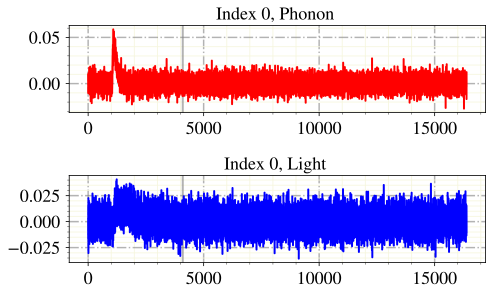

Label Phonon: 0.0
Label Light: 0.0
Assign label for event idx: 0 Phonon (q end, b back, n next, o options, i idx, p for (de)activate label list)

Phonon: q
End labeling.


In [16]:
ei.start(start_from_idx=0, print_label_list=False)

Please forward questions and correspondence about this notebook to felix.wagner(at)oeaw.ac.at.